# __Starbucks Capstone Challenge:__

__Combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type__


# __1. Business Understanding__

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. The program used to create the data simulates how people make purchasing decisions and how those decisions are influenced by promotional offers. Once every few days, Starbucks sends out an offer to users of the mobile app. 

This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products. Only the amounts of each transaction or offer are recorded.

There are three types of offers that can be sent: 
 1. __buy-one-get-one (BOGO)__: In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount
 2. __discount__: In a discount, a user gains a reward equal to a fraction of the amount spent.
 3. __informational__: In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend.
 
Some users might not receive any offer during certain weeks, and not all users receive the same offer, and that is the challenge to solve with this data set.

Each person in the simulation has some hidden traits that influence their purchasing patterns and are associated with their observable traits. People produce various events, including receiving offers, opening offers, and making purchases.

The goal is to combine transaction, demographic and offer data to: 
> __determine which demographic groups respond best to which offer type__


___
__Table of Contents:__

[1. Data exploration and cleaning](#1.-Data-exploration-and-Cleaning)

[APPENDIX - Cluster Analysis](#APPENDIX---unsupervised-Cluster-Analysis)

# __2. Data Understanding__

In [76]:
%reset -f
# must be called before importing matplotlib!!!
# %matplotlib widget

In [77]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(style='whitegrid')
plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.weight'] = 'bold'

> __to go directly to [ANALYSIS](#load)__

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## 2.1 Exploring `profile`

`profile.json` : Rewards program users (17000 users x 5 fields)
- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

In [ ]:
profile.info()

In [ ]:
profile.head()

## 2.1 Exploring `portfolio`

`portfolio.json`: Offers sent during 30-day test period (10 offers x 6 fields)
- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

In [ ]:
portfolio.info()

Every offer has a validity period before the offer expires:
- As an example, a `bogo` offer might be valid for only 5 days or 7 days. 
- `informational` offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

In [ ]:
portfolio

## 2.3 Exploring `transcript`

Transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

`transcript.json`: Event log (306648 events x 4 fields)
- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
    - offer id: (string/hash) not associated with any "transaction"
    - amount: (numeric) money spent in "transaction"
    - reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

In [ ]:
transcript.info()

In [ ]:
transcript.head()

In [ ]:
event_type = transcript['event'].unique()
print(f'we found {len(event_type)} types of offers:\n')
for evt in event_type:
    print(f'\t"{evt}"')

# __3. Data Preparation__

> All the steps taken in this section are implemented in the `lib.load_data()`

> __to go directly to [ANALYSIS](#2.-Data-Analysis)__

## 3.1 Preparing `profile` 
fitering out participants with missing values:
 - missing `age` = 118
 - missing `income` = NaN
 - missing `gender` = None

In [ ]:
profile = profile.query('age != 118')
profile.isnull().sum()

> by filtering out the `age` we removed all missing values 

In [ ]:
# we will be using id as the index 
profile.set_index('id', inplace=True)

# change `became_member_on` to datetime
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

# count number of unique users
n_users = profile.index.unique().__len__()
print(f'We found {n_users} unique participants in the profile dataset')

In [ ]:
profile.head()

## 3.2 Preparing `portfolio`

In [ ]:
# we will be using id as the index 
portfolio.set_index('id', inplace=True)

In [ ]:
# Creating code for each offer
portfolio['code'] = portfolio.apply(lambda x: x['offer_type'][0].capitalize()+'.'+str(x['duration']) +'.'+str(x['difficulty']), axis=1)
portfolio.sort_values(by=['offer_type', 'difficulty', 'duration'])

## 3.3 Preparing `transcript`

__1. We are fitering out `transcript` according to the participants available in the `profile` dataset__

In [ ]:
user_list = list(profile.index)
transcript = transcript.query('person in @user_list')
transcript.head()

In [ ]:
n_users_trans = transcript.person.unique().__len__()
print(f'We found {n_users_trans} unique participants in the transcript dataset')

__2. We are filtering out participants that did not receive any offer__

Since we will look at the offer received to measure the impact of each other we will check if all participants received at least 1 offer.

In [ ]:
user_received = transcript.query('event == "offer received"')['person'].unique()
no_offer_list = list(set(profile.index).difference(set(user_received))) # TO BE FILTERED OUT
print(f'{len(no_offer_list)} participants did not received any offer')
transcript.query('person in @no_offer_list')

__3. We are filtering out participants with no transactions__

Since we will measure the impact of each other with the transactions that occured we will check if all participants achieve at least 1 transaction.

In [ ]:
user_transactions = transcript.query('event == "transaction"')['person'].unique()
no_transaction_list = list(set(profile.index).difference(set(user_transactions))) # TO BE FILTERED OUT 
print(f'{len(no_transaction_list)} participants did not make any transactions')
transcript.query('person in @no_transaction_list')

__4. Filtering out participants with no `offer received` or no `transactions` made__

In [ ]:
participant_filter = list(set(no_offer_list + no_transaction_list))
transcript = transcript.query('person not in @participant_filter')

In [ ]:
user_profile = set(profile.index)
user_received = set(transcript.query('event == "offer received"')['person'])
user_trans = set(transcript.query('event == "transaction"')['person'])

# user_list = list(user_received.intersection(user_trans).intersection(user_profile))
user_profile.intersection_update(user_received, user_trans)
len(user_profile)

__5. Extract information from `value` dictionary and split it into `amount`, `offer_id`, and `reward`__

In [ ]:
def expand_trasncript(transcript):
    
    #change 'offer id' in 'offer_id'
    value = transcript['value'].\
        apply(lambda x:{('offer_id' if k=='offer id' else k): v for k, v in x.items()})
    
    #expand dictionary into 3 columns and add to transcript
    n_trans = transcript.join(pd.json_normalize(value))
    
    return n_trans.drop(columns=['value']) # drop obsolete columns

n_trans = expand_trasncript(transcript)
n_trans.head()

# __4. Data Analysis & Modeling__

In order to analyze the data we created to classes (see `lib.starbucks_class`):
- `Person`: participant object:
    - attributes: 
        - `_id`: participant id as found in TRANSCRIPT (`person`) and PROFILE (`id`)
        - `data`: all data contain in TRANSCRIPT
        - `offers`: offers ids from received offers
        - `total_spending`: cumulative sum of all transactions
    - methods: `get_transaction()` and `get_reward()` to collect all transactions or reward between 2 timestamps.


- `Event`: object for received offer:
    - attributes:
        - `_id`: index of the received offer in TRANSCRIPT
        - `offer_id`: offer id as found in PROFILE
        - `details`: all details of the specific offer id as found in PROFILE (duration, difficulty, ...)
        - `offer_type`: offer type (bogo, discount, or informational)
        - `start`: time (in hours) where the offer was received
        - `end`: time (in hours) where the offer is supposed to end (based on offer duration)
        - `events`: subset of TRANSCRIPT from start to end
        - `viewed`: timestamp (hours) if this offer was viewed, np.nan if not
        - `completed`: timestamp (hours) if this offer was completed, np.nan if not
        

In [ ]:
import numpy as np
import pandas as pd
from lib.starbucks_class import Person, Event, PORTFOLIO, PROFILE, TRANSCRIPT

## 4.1. Data Analysis

### 4.1.1. Visualizing the time-line of events for one individual

In [4]:
# gathering information from a participant included in TRANSCRIPT
user_list = TRANSCRIPT.person.unique()
user_id = user_list[0]
User = Person(user_id)
User.data

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
13251,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
41870,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN
41871,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
43605,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN
46921,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
74922,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,216,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
76569,78afa995795e4d85b5d9ceeca43f5fef,transaction,222,NaN,19.67,NaN
81042,78afa995795e4d85b5d9ceeca43f5fef,transaction,240,NaN,29.72,NaN
124503,78afa995795e4d85b5d9ceeca43f5fef,transaction,378,NaN,23.93,NaN


In [5]:
# gathering information about a received offer from User
Offer = Event(User.offers[0], User.data)
Offer.events

,person,event,time,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
13251,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
41870,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,NaN,19.89,NaN
41871,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0
43605,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,NaN,17.78,NaN
46921,78afa995795e4d85b5d9ceeca43f5fef,offer received,168,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN


In [16]:
from lib.data_visualization import time_line

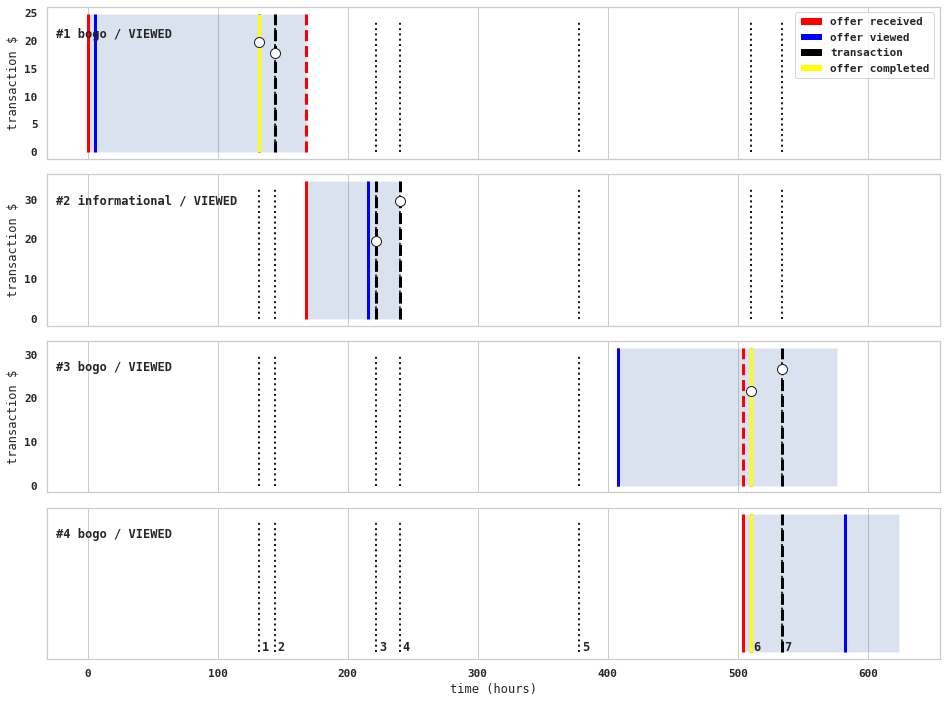

In [73]:
f, ax = plt.subplots(len(User.offers),1, sharex=True, figsize=[16,12])
plt.subplots_adjust(hspace=0.1)
cnt=0

all_trans = User.get_transaction(0, User.data['time'].values[-1])

for idx in User.offers:
    plt.sca(ax[cnt])
    legend = True if cnt == 0 else False
    xlabel = True if cnt == len(ax)-1 else False
    Offer = Event(idx, User.data)
    trans_viewed = User.get_transaction(Offer.viewed, Offer.end)
    time_line(Offer, trans_viewed, legend=legend, xlabel=xlabel, text='#'+str(cnt+1)+' ')
        
    cnt +=1
    
for ax_n in ax:
    ymax = ax_n.get_ylim()[1]*.9
    ax_n.vlines(
        x=all_trans.time, 
        ymax=ymax, ymin=0, 
        color='k', 
        linestyle='dotted', 
        lw=2,
        zorder=0
    )
    

# ax[cnt].vlines(
#     x=all_trans.time, 
#     ymax=1, ymin=0, 
#     color='k', 
#     linestyle='dotted', 
#     lw=2
# )

offset=2
for n, x in enumerate(all_trans.time):
    ax[-1].text(
        x+offset, 0.01,
        str(n+1),
        weight='bold',
        ha='left'
    )

# ax[cnt].text(
#     0.01,0.8,
#     'All transactions', 
#     weight='bold',
#     ha='left',
#     transform=ax[cnt].transAxes
# )
# ax[cnt].set_xlabel('time (hours)')
# ax[cnt].yaxis.set_visible(False)

plt.show()

if True:
    f.savefig('./assets/Timeline.png', dpi=300)

This visualization represents all the events that occured over 30 days (720 hours) of data collection for one participant. 

Each row represents an offer received by this individual. The light blue block represents the duration of the offer. In this example, the participants received 4 offers: 3 `bogo` and 1 `informational`.

For each offer, 4 different events are marked:
 - offer received (red): When an offer was received. 
 - offer viewed (blue): When an offer is viewed
 - transacton (black): When a transaction is made
 - offer completed (yellow): When an offer is completed

The 7 transactions for this individual are shown accross the offers as black dotted lines. The transactions are not specific to an offer, and a difficulty of this analysis was to assign transactions to specific offers.
 
Few considerations:
> offer can overlap: offer #4 starts during offer #3

> transactions can be made before, during, or after an offer. We can find transactions between 2 offers (see transaction 5)

We decided to assign a transaction to an offer (marked with white dot) if:
 - the transaction was made during the duration of the offer
 - the transaction was made after the offer was viewed
 


### 4.1.2 Creating metrics for analysis

 - amount of transaction for _viewed_ offer
 - total amount of transaction (_viewed_ and _not viewed_)
 - amount of rewards

In [74]:
result = []

for user_id in set(TRANSCRIPT.person):
    User = Person(user_id)
    PROFILE.loc[User._id,'total_spending'] = User.total_spending
    PROFILE.loc[User._id,'total_offers'] = len(User.offers)

    for _id in User.offers:
        evt = Event(_id, User.data)    
        trans = User.get_transaction(evt.viewed, evt.end) # transcations after offer is viewed
        trans_all = User.get_transaction(evt.start, evt.end) # all trasnsactions
        reward = User.get_reward(evt.viewed, evt.end) # reward after offer is viewed
        reward_all = User.get_reward(evt.start, evt.end) # all reward
        
        # results
        res_trans = np.sum(trans.amount) if len(trans) > 0 else 0 # total spent when offer viewed
        res_reward = np.sum(reward.reward) if len(reward) > 0 else 0
        res_trans_all = np.sum(trans_all.amount) if len(trans_all) > 0 else 0
        res_reward_all = np.sum(reward_all.reward) if len(reward_all) > 0 else 0
        res_tag_viewed = 1 if evt.viewed else 0 # tag offer viewed
                
        result.append([
            user_id,
            evt.offer_id,
            evt.offer_type,
            res_trans_all,
            res_trans,
            res_reward_all,
            res_reward,
            res_tag_viewed,
        ])

# results
RES = pd.DataFrame(result, columns=[
    'profile_id', 
    'portfolio_id',
    'portfolio_type',
    'amount_received',
    'amount_viewed',
    'reward_received',
    'reward_viewed',
    'view_tag',
])



In [75]:
# save results and modified PROFILE to avoid running the analysis
if True:
    #save data into ./data/ for future use
    RES.to_csv('./data/res.csv',index=False)
    PROFILE.to_csv('./data/profile.csv')

___
<a name="load"></a>LOADING RESULTS

[back to import](#2.-Data-Understanding)

In [78]:
RES = pd.read_csv('./data/res.csv')
PROFILE = pd.read_csv(
    './data/profile.csv', 
    index_col='id', 
    dtype={
        'gender':'category'
    },
    parse_dates=['became_member_on']
)
RES_copy = RES.copy()
RES_copy.head()

,profile_id,portfolio_id,portfolio_type,amount_received,amount_viewed,reward_received,reward_viewed,view_tag
0,4866a2c8fedd46b98dc2c695f8cc5840,5a8bc65990b245e5a138643cd4eb9837,informational,16.83,0.0,0.0,0.0,1
1,4866a2c8fedd46b98dc2c695f8cc5840,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,69.17,0.0,5.0,0.0,1
2,4866a2c8fedd46b98dc2c695f8cc5840,5a8bc65990b245e5a138643cd4eb9837,informational,22.58,0.0,5.0,0.0,1
3,4866a2c8fedd46b98dc2c695f8cc5840,3f207df678b143eea3cee63160fa8bed,informational,13.49,0.0,0.0,0.0,1
4,1853362ad12c41bc8d7fefc8bafbe90a,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,32.92,0.0,5.0,0.0,1


## 4.2. Modeling

(TO BE UPDATED)\
In order to use `PROFILE` later on as features we are going to categorize all `profile` columns:
 - `age` is being splitted into 8 age brackets
 - only the year is kept from `became_member_on`. These values are being transformed into category
 - `income` is being splitted into 8 income brackets

In [ ]:
feat_profile = pd.DataFrame()

#age brackets
'''divide age in 8 brackets'''
bins_age = [0, 25, 35, 45, 55, 65, 75, 85, 110]
lab_age = ['<25', '25-34', '35-44', '45-54', '55-64', '65-74', '75-84', '>85']
feat_profile['age_brackets'] = pd.cut(profile['age'], bins=bins_age, labels=lab_age, right=False)

#membership year
'''keep only the year of membership'''
feat_profile['year_member'] = profile['became_member_on'].apply(lambda x:x.year)
feat_profile['year_member'] = feat_profile['year_member'].astype('category')

#income brackets
'''divide income in 8 brackets'''
bins_income = [30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 120000]
lab_income = ['<40k', '40k-49k', '50k-59k', '60k-69k', '70k-79k', '80k-89k', '90k-99k', '>100k']
feat_profile['income_brackets'] = pd.cut(profile['income'], bins=bins_income, labels=lab_income, right=False)

feat_profile = feat_profile.join(profile['gender'])
feat_profile.head()

# __5. Model Evaluation & Results__

# __6. Conclusion & Deployment__

### 1.5 Distribution of Offer type in `transcript`

In [ ]:
TRANSCRIPT =  expand_trasncript(pd.read_json('data/transcript.json', orient='records', lines=True))
offer_distribution = TRANSCRIPT.query('event == "offer received"')['offer_id'].value_counts(normalize=True)
offer_distribution = offer_distribution.to_frame(name="received ratio")
offer_distribution['type'] = portfolio.loc[offer_distribution.index, 'offer_type']
offer_distribution.sort_values('type')

### 1.6 Analysis of events time-line

- `offer received` should trigger the offer duration (`portfolio`)
- `offer viewed` should tag this event in success metrics
- `transaction` & `reward` should build the succes metrics

In [ ]:
#reset variable
del transcript, portfolio, profile

In [ ]:
plt.rcParams['figure.figsize']=[10,10]

style_evt = {
    'offer received':'red',
    'offer viewed':'blue',
    'transaction':'black',
    'offer completed':'yellow'
}

from matplotlib.patches import Patch


legend_elements = [
    Patch(facecolor='red', label='offer received'),
    Patch(facecolor='blue', label='offer viewed'),
    Patch(facecolor='black', label='transaction'),
    Patch(facecolor='yellow', label='offer completed')
]

def time_line(event, transactions=[], legend=False):
    ax = plt.gca()
    ymax = 10
    tag = 'VIEWED' if event.viewed > 0 else 'not viewed'
    text = event.details['offer_type'].values[0] + ' / ' +tag
    evt_list = evt.events['event'].tolist()
    color_list = [style_evt[k] for k in evt_list]
    
    
    if len(transactions) > 0:
        ymax = transactions.amount.max()
        ax.plot(transactions.time, transactions.amount, 'ko')
        
    ax.vlines(x=event.events['time'], ymax=ymax, ymin=0, color=color_list)
    ax.fill_between(x=[event.start,event.end], y1=[0,0], y2=[ymax,ymax], alpha=.2)
    ax.set_title(text, ma='right')
    ax.set_xlabel('time (hours)')
    ax.set_ylabel('transaction $')
    
    if legend:
        ax.legend(handles=legend_elements, loc='best')
    
        

In [ ]:
PROFILE.total_offers.hist(bins=6)

### Joining Metrics and Features

In [ ]:
RES_copy.groupby(by=['profile_id','portfolio_type']).agg({'amount_viewed':'mean', 'amount_received':'sum'})

In [ ]:
df = RES_copy.groupby(by=['profile_id','portfolio_type'])['amount_viewed'].mean()
df = df.unstack()
# df.columns = [x[0].split('_')[0]+'_'+x[1] for x in df.columns] # reduce multilevel and change columns names
df.head()

 - joining features for each participants

In [ ]:
df = df.join(PROFILE)
df['offer_avg'] = df.total_spending.div(df.total_offers)
df.head()

### __Descriptive statistics__

We are using this table of descriptive statisctis to filter out the dataset to the most relevant subset of data.

In [ ]:
descriptive_stats = df.describe()
descriptive_stats

To filter out outliers values we are following the traditional definition of values outside of the Inter Quartile Range. We are setting an order of priority in the filtering process:
1. `total_spending`
2. `bogo` and `discount`
3. `informational`

In order to keep the maximum amount of data we decided to stop the filtering if the number of participants decrease below 80% of the original dataset.

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 8))
f.suptitle("Original dataset", fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.8)
win=0
cols = ['total_spending', 'bogo', 'discount', 'informational', 'income', 'age']

for i in cols:
    sns.boxplot(data=df, x='gender', y=i, ax=ax[win], palette='colorblind')
    win += 1

In [ ]:
cols = [ 'total_spending', 'bogo', 'discount', 'informational']

subdf = df.copy()

# remove low total_spending at q1
q1 = descriptive_stats['total_spending']['25%']
q3 = descriptive_stats['total_spending']['75%']
iqr = q3-q1
low = 10
up = q3 + (1.5 * iqr)
subdf = subdf.query('@low < total_spending < @up')

print(f'The new dataset has {len(subdf)} participants\n')

f, ax = plt.subplots(nrows=1, ncols=6, figsize=(20, 8))
f.suptitle("Filtered dataset", fontsize=14, fontweight='bold')
plt.subplots_adjust(wspace=0.8)
win=0
cols = ['total_spending', 'bogo', 'discount', 'informational', 'income', 'age']

for i in cols:
    sns.boxplot(data=subdf, x='gender', y=i, ax=ax[win], palette='Blues')
    if i in ['bogo', 'discount', 'informational']:
        ax[win].set_ylim(top=300)
    win += 1
    

In [ ]:
subdf.describe()

## __REGRESSION__

 - What model?
 - Do we need categorical features?

In [ ]:
from lib.data_wrangling import create_features
features = create_features(PROFILE)
features = features.loc[subdf.index, :]
features

In [ ]:
sns.boxplot(x=features.income_brackets, y=df_ratio.bogo, palette="Blues")

 - computing spending ratio for each offer type (ratio spent after a type of offer is viewed over the total spending)

In [ ]:
df_ratio = subdf[['bogo', 'discount', 'informational']].div(subdf.total_spending, axis='rows')
df_ratio

In [ ]:
df_response = subdf[['bogo', 'discount', 'informational']].gt(subdf.offer_avg, axis='rows').astype(int)
df_response

In [ ]:
toto = subdf[['bogo', 'discount', 'informational']].median()
toto

In [ ]:
subdf['bogo'].gt(toto.bogo, axis='rows').sum()

In [ ]:
subdf = subdf.join(df_response, rsuffix='lab')

In [ ]:
sns.pairplot(subdf, hue='bogolab',corner=True)

In [ ]:
# Generate correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(h_neg=10, h_pos=220, s=60,as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap,vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .8}, annot=True)

### 2.2. Offer Viewed:

In [ ]:
viewed_stack = RES.query('profile_id in @subdf.index').groupby('portfolio_type')['view_tag'].value_counts()
x_table = viewed_stack.unstack()
x_table.columns = ['not viewed', 'viewed']
x_table

In [ ]:
from scipy.stats import chi2_contingency
chi2, p, dof, expected = chi2_contingency(x_table)
print(f'the probability of the distribution to be homogeneous is p = {p:.2}')
if p < 0.5:
    print('\tWe can reject the null hypothesis')
else:
    print('\tWe cannot reject the null hypothesis')

In [ ]:
ax = x_table.subtract(expected).plot(kind='bar', y='viewed')
ax.set_title('Difference to expected in number of viewed offer')
plt.show()

> we can conclude that the type of offer impact the number of viewed offer.
It looks like `discount` and `informational` offers were more viewed that `bogo`

In [ ]:
df_X = df_ratio
cat = 'spending_brackets'
list_cat = list(features[cat].cat.categories)
col = sns.color_palette("colorblind", len(list_cat))
palette = [col[k] for k in features[cat].cat.codes]

f = plt.figure()
ax = Axes3D(f)
sc = ax.scatter3D(
    df_X.bogo,
    df_X.discount, 
    df_X.informational,
    marker='o',
    edgecolor='k',
    c=features[cat].cat.codes
)

plt.xlabel('Buy-One-Get-One')
plt.ylabel('Discount')
ax.set_zlabel('Informational')

handles, _ = sc.legend_elements()
labels = features[cat].cat.categories.tolist()
ax.legend(handles, labels)

In [ ]:
plt.figure()
pie_gender = df.gender.value_counts(normalize=True).to_frame()
pie_gender
plt.pie(
    data=pie_gender,
    x='gender',
    autopct='%.2f',
    labels=pie_gender.index,
    normalize=False
)
plt.show()

---
---
# __APPENDIX - unsupervised Cluster Analysis__
## __Clustering Analysis__

__1. K_pod method to apply kmeans to dataset with missing data__

 - (reference)
 - (explanation)

In [ ]:
from kPOD import k_pod

In [ ]:
cluster_df = df_ratio
cluster_df

In [ ]:
#set the number of clusters
k=4

# use data with missing values to perform clustering
clustered_data = k_pod(cluster_df.to_numpy(), k)

In [ ]:
cluster_labels = clustered_data[0]

In [ ]:
for offer in cluster_df:
    sns.violinplot(
        x=cluster_labels,
        y=offer,
        data=cluster_df,
        scale_hue=False
    )
    plt.ylabel(f'{offer}')
    plt.show()

__2. Tradiational Kmeans clustering by changing missing values with median__

We are replacing each missing values with the median from the related category: `bogo`, `discount`, or `informational` 

In [ ]:
# RES_median = RES_ratio.apply(lambda x: x.fillna(x.median()),axis=0)
RES_median = cluster_df.apply(lambda x: x.fillna(x.median()),axis=0)

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
import matplotlib.cm as cm

range_n_clusters = list(range(2,10))

X = RES_median.to_numpy()


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 20])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    if True:
        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

plt.show()

__3. Implementing silhouette analysis to k-pod__

In [ ]:
%matplotlib inline

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
from kPOD import k_pod
import matplotlib.cm as cm

range_n_clusters = list(range(2,9))

X = cluster_df.copy().to_numpy()

def replace_by_centroids(data, labels, centers):
    #locate missing data
    locs = np.argwhere(np.isnan(data))
    for i in locs:
        row=i[0]
        col=i[1]
        lab = int(labels[row])
        center = centers[lab][col]
        
        data[row,col] = center
    
    return data


for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 1 column
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 20])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = k_pod(n_clusters=n_clusters, data=X)
    cluster_labels = clusterer[0]
    centers = clusterer[1]
    
    # replace missing data with centroids
    X = replace_by_centroids(X, cluster_labels, centers)
    
    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    
    # Draw white circles at cluster centers
    centers = np.vstack(centers)
    ax2.scatter(centers[:,0], centers[:,1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [ ]:
plt.plot(df_X['total_spending'])

### __3D Graphical representation__

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
%matplotlib auto

In [ ]:
X = cluster_df.to_numpy()
clusterer = k_pod(n_clusters=3, data=X)
cluster_labels = clusterer[0]
centers = clusterer[1]

# replace missing data with centroids
X = replace_by_centroids(X, cluster_labels, centers)

In [ ]:
col = sns.color_palette("colorblind", len(cluster_labels))
palette = [col[int(x)] for x in cluster_labels]

f = plt.figure(figsize=(6,6))
ax = Axes3D(f)
ax.scatter3D(
    cluster_df.bogo, 
    cluster_df.discount, 
    cluster_df.informational,
    marker='o',
    edgecolor='k',
    c=palette
)

plt.xlabel('Buy-One-Get-One')
plt.ylabel('Discount')
ax.set_zlabel('Informational')

In [ ]:
X[0]

## __Building ML model over multiple outputs__

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = df.bogo.dropna()
X = pd.get_dummies(features.loc[y.index,:])

X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), y.to_numpy(), test_size=0.2)

In [ ]:
from sklearn.linear_model import SGDRegressor
from sklearn import svm

In [ ]:
# model = SGDRegressor(loss='huber', penalty='elasticnet')
model = svm.SVR()

In [ ]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [ ]:
model.score(X_test, y_test)

In [ ]:
plt.plot(y_test, preds, 'o')

In [ ]:
df.head()

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
coder = OneHotEncoder()
gender = coder.fit_transform(df['gender'].to_numpy().reshape(-1, 1))

In [ ]:
gender.toarray()

### PROFILE (APPENDIX)
Quick visualization of the PROFILE dataset

In [ ]:
PROFILE.head()

In [ ]:
f1, ax1 = plt.subplots(1,1, figsize=[16,8])
gender = PROFILE

f2, ax2 = plt.subplots(1,3, figsize=[16,8])
plt.subplots_adjust(wspace=0.3)


sns.violinplot(
    data=PROFILE,
    x='income',
    y='gender',
    ax=ax[0],
    inner='box',
    scale='area',
    orient='h'
)
ax2[0].set_title('Ditribution of INCOME by gender')

sns.violinplot(
    data=PROFILE,
    x='age',
    y='gender',
    ax=ax2[1],
    orient='h'
)
ax2[1].set_title('Ditribution of AGE by gender')

PROFILE.groupby('gender')['became_member_on'].value_counts().unstack(0).cumsum()[::20].plot(ax=ax[2],marker='o')
ax2[2].set_title('Cumulative Sum of MEMBERSHIP from 2014 to 2019')
plt.show()

__1. Are all offers distributed equally among `TRANSCRIPT` ?__

In [ ]:
offer_distribution = TRANSCRIPT.query('event == "offer received"')['offer_id'].value_counts(normalize=True)
offer_distribution = offer_distribution.to_frame(name="received ratio")
offer_distribution['type'] = PORTFOLIO.loc[offer_distribution.index, 'offer_type']
offer_distribution = offer_distribution.sort_values('type')
offer_distribution.style.format({'received ratio':"{:.2%}"})

In [ ]:
plt.rcParams['figure.figsize'] = 8, 8
pie_data = offer_distribution.groupby('type').sum()
pie_data
plt.pie(
    data=pie_data, 
    x='received ratio', 
    labels= pie_data.index, 
    autopct='%.2f'
)
plt.title('Distribution of each offer type in transcript')
plt.show()